In [1]:
import ROOT as r
import numpy as np

Welcome to JupyROOT 6.24/06


In [2]:
def MakeWiggle(hist2d_t_e, hist_name, e_start, e_end):
    start_bin = hist2d_t_e.GetYaxis().FindBin(e_start)
    end_bin = hist2d_t_e.GetYaxis().FindBin(e_end)
    wiggle_T = hist2d_t_e.ProjectionX(hist_name, start_bin, end_bin)
    return wiggle_T

def Normalize(hist, start_bin):
    start_time = hist.GetBinCenter(start_bin)
    integral = hist.Integral(start_bin, 4356) * np.exp(start_time/64)
    normalized_lm = hist.Clone('normalized_from_{:.2f}us'.format(start_time))
    normalized_lm.SetTitle('Normalized lost muon from {:.2f}us'.format(start_time))
    normalized_lm.Scale(1/integral)
    return normalized_lm

def Integral(hist, start_bin):
    start_time = hist.GetBinCenter(start_bin)
    integral_lm = hist.Clone('integrate_from_{:.2f}us'.format(start_time))
    integral_lm.Reset()
    integral_lm.SetTitle('Integral lost muon from {:.2f}us'.format(start_time))
    sum_lm = 0
    for i in range(start_bin, hist.GetNbinsX()+1):
        t_prime = hist.GetBinCenter(i)
        sum_lm += hist.GetBinContent(i) * np.exp(t_prime/64.43)
        integral_lm.SetBinContent(i, sum_lm)

    return integral_lm

def stat_energy_bin(hist2d_t_e, tag=""):
    # Statistical energy bin
    hists_stat_ebin = []
    average_energys = []
    hist_e = hist2d_t_e.ProjectionY()

    n_bin = 50
    n_per_bin = hist2d_t_e.GetSum() / n_bin
    hist2d_t_e.GetNbinsY()

    start_bin = 1
    end_bin = start_bin
    count = 0
    n_now = 0
    total_energy = 0

    for i in np.arange(1, hist2d_t_e.GetNbinsY() + 1):
        n_now += hist_e.GetBinContent(int(i))
        total_energy += hist_e.GetBinCenter(int(i)) * hist_e.GetBinContent(int(i))
        end_bin = int(i)
        if (n_now >= n_per_bin):
            hists_stat_ebin.append(hist2d_t_e.ProjectionX(f"hist_stat_ebin{count}{tag}", start_bin, end_bin))
            average_energys.append(total_energy/n_now)
            print(f"count {count}, start_bin {start_bin}, end_bin {end_bin}, average energy {total_energy/n_now}")
            count += 1
            start_bin = int(i + 1)
            n_now = 0
            total_energy = 0

    ave_energy_tarray = r.TArrayD(len(average_energys))
    for i, average_energy in enumerate(average_energys):
        ave_energy_tarray[i] = average_energy
        # print(tarray[i])
    
    return hists_stat_ebin, ave_energy_tarray

In [4]:
f = r.TFile.Open("../run/dataset/toymc_run120A.root")
out = r.TFile.Open("../run/dataset/toymc_run120A_ana.root", "update")
hist2d_t_e = f.Get("hist2d_t_e")
hist2d_t_e_inv_ratio = f.Get("hist2d_t_e_inv_ratio")

hists_stat_ebin, ave_energy_tarray = stat_energy_bin(hist2d_t_e)
hists_stat_ebin_inv_ratio, ave_energy_tarray_inv_ratio = stat_energy_bin(hist2d_t_e_inv_ratio, tag="_inv_ratio")

# Write
out.cd()
out.mkdir("stat_energy_bin")
out.cd("stat_energy_bin")
for hist_stat_ebin in hists_stat_ebin:
    hist_stat_ebin.Write()
out.WriteObject(ave_energy_tarray, "average_energy_col")

out.cd("../")
out.mkdir("stat_energy_bin_inv_ratio")
out.cd("stat_energy_bin_inv_ratio")
for hist_stat_ebin_inv_ratio in hists_stat_ebin_inv_ratio:
    hist_stat_ebin_inv_ratio.Write()
out.WriteObject(ave_energy_tarray_inv_ratio, "average_energy_col_inv_ratio")
out.Close()

count 0, start_bin 1, end_bin 4, average energy 20.021128697381148
count 1, start_bin 5, end_bin 8, average energy 59.991799601102436
count 2, start_bin 9, end_bin 12, average energy 99.99062710767346
count 3, start_bin 13, end_bin 16, average energy 140.00757866518265
count 4, start_bin 17, end_bin 20, average energy 180.00288291938904
count 5, start_bin 21, end_bin 24, average energy 219.99118580148289
count 6, start_bin 25, end_bin 28, average energy 259.99338103613474
count 7, start_bin 29, end_bin 32, average energy 299.96741608958615
count 8, start_bin 33, end_bin 36, average energy 339.9776328462735
count 9, start_bin 37, end_bin 40, average energy 379.98361321272
count 10, start_bin 41, end_bin 44, average energy 419.9769407684805
count 11, start_bin 45, end_bin 48, average energy 459.99103987101165
count 12, start_bin 49, end_bin 52, average energy 499.9781980201679
count 13, start_bin 53, end_bin 56, average energy 539.9665085184985
count 14, start_bin 57, end_bin 60, average

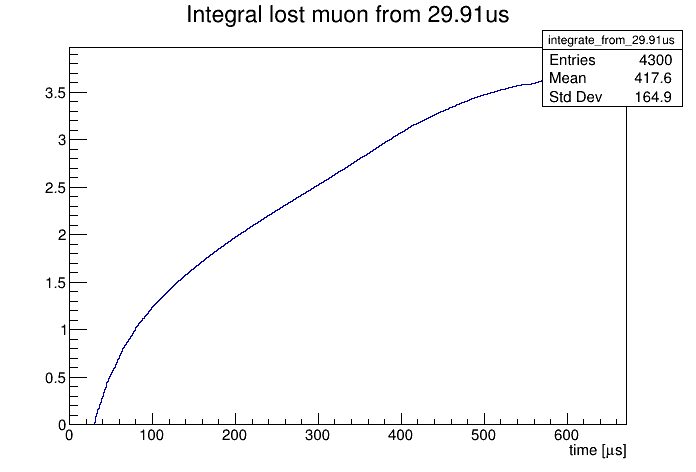

In [3]:
c = r.TCanvas()
f = r.TFile.Open("../run/dataset/toymc_run130A.root")
hist2d_t_e = f.Get("hist2d_t_e")
hist2d_t_e_inv_ratio = f.Get("hist2d_t_e_inv_ratio")
hist_lm = f.Get("hist1d_time_lost")
hist_lm_inv_ratio = f.Get("hist1d_time_lost_inv_ratio")

wiggle_T = MakeWiggle(hist2d_t_e, "wiggle_T", 1700, 3100)
wiggle_T_inv_ratio = MakeWiggle(hist2d_t_e_inv_ratio, "wiggle_T_inv_ratio", 1700, 3100)

wiggles_energy_bin = []
for energy in range(1000, 3100, 100):
    wiggles_energy_bin.append(MakeWiggle(hist2d_t_e, f"wiggle_e{energy}", energy, energy+100))

wiggles_energy_bin_inv_ratio = []
for energy in range(1000, 3100, 100):
    wiggles_energy_bin_inv_ratio.append(MakeWiggle(hist2d_t_e_inv_ratio, f"wiggle_e{energy}_inv_ratio", energy, energy+100))

normalized_lm = Normalize(hist_lm, start_bin=201)
integral_lm = Integral(normalized_lm, start_bin=201)

normalized_lm_inv_ratio = Normalize(hist_lm_inv_ratio, start_bin=201)
integral_lm_inv_ratio = Integral(normalized_lm_inv_ratio, start_bin=201)
integral_lm.Draw()
c.Draw()

out = r.TFile("../run/dataset/toymc_run130A_ana.root", "recreate")

out.mkdir("lost_muon")
out.cd("lost_muon")
hist_lm.Write("hist_lm")
hist_lm_inv_ratio.Write("hist_lm_inv_ratio")
integral_lm.Write("hist_lm_integral")
integral_lm_inv_ratio.Write("hist_lm_integral_inv_ratio")

out.cd("../")
out.mkdir("wiggle")
out.cd("wiggle")
wiggle_T.Write("wiggle_T")
wiggle_T_inv_ratio.Write("wiggle_T_inv_ratio")

out.cd("../")
out.mkdir("energy_bin")
out.cd("energy_bin")
for wiggle_energy_bin in wiggles_energy_bin:
    wiggle_energy_bin.Write()
for wiggle_energy_bin_inv_ratio in wiggles_energy_bin_inv_ratio:
    wiggle_energy_bin_inv_ratio.Write()

out.Close()